In [17]:
import pickle
# import matlab.engine
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy import signal
import pickle
import pandas as pd
# there were a lot of deprecation warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import butter,filtfilt

In [18]:
# functions for easy work

def get_hour(hour: int):
    filename= 'Hour' + str(hour)
    with open(filename, 'rb') as data_file:
        data = pickle.load(data_file)
        print("data.size = " + str(data.size))
        data = np.array(data)
        print("data: " + str(data))
        return data
        
def plot_data(data: np.array, title: str):
    plt.figure(figsize=(13,4))
    plt.plot(data)
    plt.title(title, fontsize=20)
    plt.ylabel('Voltage', fontsize=16)
    plt.show()
    
def low_pass_filter(data: np.array, T=3600.0, fs=20000.0, cutoff=100, order=2):
    # Filter requirements.
    # T = 3600.0         # Sample Period, sec
    # fs = 20000.0       # sample rate, Hz
    # cutoff = 100      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
    # order = 2       # sin wave can be approx represented as quadratic
    nyq = 0.5 * fs  # Nyquist Frequency
    n = int(T * fs) # total number of samples
    
    # Filter the data,
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
    
def downsample(data: np.array, sample_rate=20000.0, downsample_rate=250.0):
    # sample_rate = 20000.0
    # downsample_rate = 250.0
    downsample_factor = sample_rate / downsample_rate
    downsampled_data = scipy.signal.decimate(data, int(downsample_factor))
    return downsampled_data

def autocorrelation_order(data: np.array, log_range=7):
    autocorrelation = []
    correlation = np.corrcoef(data, data)[0,1]
    print(correlation)
    autocorrelation.append(correlation)
    for log_shift in range(7):
        shift = 10 ** log_shift
        correlation = np.corrcoef(data[:-shift], data[shift:])[0,1]
        print(shift)
        print(correlation)
        autocorrelation.append(correlation)
    plt.plot(autocorrelation)
    plt.title('Autocorrelation: change in order size shifts', fontsize=20)
    plt.show()
    
def my_autocorrelation(data: np.array, shifts_range, shifts_jump=1, shifts_lst=[]):
    autocorrelation = []
    correlation = np.corrcoef(data, data)[0,1]
    autocorrelation.append(correlation)
    if shifts_lst != []:
        shifts = shifts_lst
    else:
        shifts = range(1, shifts_range, shifts_jump)
    for shift in shifts:
        correlation = np.corrcoef(data[:-shift], data[shift:])[0,1]
        if shifts_lst != []:
            print("shift = " + str(shift))
            print("correlation = " + str(correlation))
        autocorrelation.append(correlation)
    return autocorrelation

def plot_statesmodel_autocorrelation(data: np.array):
    print(data.size)
    with mpl.rc_context():
        mpl.rc("figure", figsize=(13,4))
        plot_acf(data)
        
def data_presentation(data: np.array, start:tuple, end: tuple):
    plot_data(data, 'Raw Data - Wakefulness : %d:%d:%d-%d:%d:%d' % (start[0], start[1], start[2], end[0], end[1], end[2]))
    # low pass filter
    lpf_data = low_pass_filter(data)
    plot_data(lpf_data, 'Raw Data - Wakefulness : %d:%d:%d-%d:%d:%d, Butter Low Pass Filter' % (start[0], start[1], start[2], end[0], end[1], end[2]))
    # downsample
#     ds_data = downsample(data)
#     plot_data(ds_data, 'Raw Data - Wakefulness : %d:%d:%d-%d:%d:%d, downsampled to 250Hz' % (start[0], start[1], start[2], end[0], end[1], end[2]))

def minute_to_sample(minute: int, sample_rate=20000, start_sample=0):
    return second_to_sample(60*minute, start_sample)

def second_to_sample(second: int, sample_rate=20000, start_sample=0):
    return second * 20000 + start_sample

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pickle
import os
from sklearn.cluster import AgglomerativeClustering

# there were a lot of deprecation warnings
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)


def get_hour(hour: int, dir='/home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/Data/pickel_files'):
    """
    Gets data of a specific hour as np.array,
    given the directory and files are in the specific format:
    file name is 'Hour#' and is in a directory called dir,
    prints data's size
    :param hour: hour in int
    :param dir: name of data directory
    :return: data as np.array (prints it's size)
    """
    filename = dir + os.path.sep + 'Hour' + str(hour)
    # TODO: if using jupyter, replace with following line:
    # filename = 'Hour' + str(hour)
    with open(filename, 'rb') as data_file:
        data = pickle.load(data_file)
        data = np.array(data)
        print("data.size = " + str(data.size))
        return data


def plot_data(data: np.array, title: str):
    """
    :param data: raw recording
    :param title: title of graph
    shows / saves a plot of the data
    """
    plt.figure(figsize=(13, 4))
    plt.plot(data)
    plt.title(title, fontsize=20)
    plt.ylabel('Voltage', fontsize=16)
    plt.xlabel('Time', fontsize=16)
    plt.show()
    plt.savefig('data')
    plt.close()


def welch_psd_per_bin(data: np.array, bin_length_sec=10, sf=20000,
                      nperseg=20000, noverlap=10000, scaling='spectrum'):
    """
    :param data: 1 hour of data
    :param bin_length_sec:  length of bins in seconds
    :params sf: sample frequency (samples/second)
    :param nperseg: length of segment in samples
    :param noverlap: overlap between segments in samples
    :param scaling: no reason to change default
    :return: array of relevant frequencies, array of their magnitudes
    """
    samples_per_bin = int(bin_length_sec * sf)
    samples_per_bin = 9000
    print(int(data.size / samples_per_bin))
    spectrum = []
    for i in range(int(data.size / samples_per_bin)): # for each bin compute the spectrum
        single_bin = data[i * samples_per_bin:samples_per_bin * (i + 1)]
        frequencies, density = signal.welch(single_bin, fs=sf, nperseg=nperseg, noverlap=noverlap, scaling=scaling)
        spectrum.append(density)
    return frequencies, np.array(spectrum)

def show_spectogram(frequencies, spectrum: np.array, size=360, N_freqs=30):
    """
    :param frequencies: relevant frequencies - eventually takes the first 30
    :param spectrum: magnitudes of the relevant frequencies in each bin
    :param size: number of bins (default is one hour with bins' length 10sec - 360
    :return: shows / saves spectogram
    """
    # segmentation and plot
    plt.pcolormesh([i for i in range(size)], frequencies[:N_freqs], np.abs(np.log(np.transpose(spectrum[:, :N_freqs]))),
                   shading='gouraud')
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time')
    plt.show()
    plt.savefig('spectogram')
    plt.close()

def show_normalized_spectogram(frequencies, spectrum: np.array, no_show=False, size=360):
    """
    :param frequencies: relevant frequencies - eventually takes the first 30
    :param spectrum: magnitudes of the relevant frequencies in each bin
    :param size: number of bins (default is one hour with bins' length 10sec - 360
    :param no_show: if there's no need to show the spectogram
    :return: normalized magnitudes for the frequencies (shows/saves spectogram figure)
    """
    # normalize spectogram data
    low_freq_power = spectrum[:, :30]  # all bins, frequencies upto 30Hz
    # calculate avarage freq power
    avg_freq_power = low_freq_power.mean(axis=0)  # for each frequency, its average magnitude
    norm_freq_power = low_freq_power / avg_freq_power
    # segmentation and plot
    if no_show:
        return norm_freq_power
    plt.pcolormesh([i for i in range(size)], frequencies[:30], np.abs((np.transpose(norm_freq_power))),
                   shading='gouraud')
    plt.title('STFT Normalized Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time')
    plt.show()
    plt.savefig('normalized_spectogram')
    plt.close()
    return norm_freq_power


def show_corr_mat(norm_freq_power, no_show=False):
    low_freq_magnitudes = np.abs(norm_freq_power)
    # compute correlation matrix of frequencies magnitudes
    corr_mat = np.corrcoef(low_freq_magnitudes)  # by pearson
    corr_mat.shape
    if no_show:
        return corr_mat, low_freq_magnitudes
    plt.imshow(corr_mat)
    plt.colorbar()
    plt.show()
    #     plt.savefig('corr_mat')
    plt.close()
    return corr_mat, low_freq_magnitudes


def show_clustered_data(corr_mat, low_freq_magnitudes, no_show=False):
    # re-organize the segments according to clusters
    ward_clusters = AgglomerativeClustering(linkage='ward').fit(corr_mat)
    indices = np.argsort(ward_clusters.labels_)
    magnitudes_by_clusters = low_freq_magnitudes[indices]
    corr_mat_by_clusters = np.corrcoef(magnitudes_by_clusters)
    corr_mat_by_clusters.shape
    if no_show:
        return ward_clusters
    plt.imshow(corr_mat_by_clusters)
    plt.clim(-1, 1)
    plt.colorbar()
    #     plt.savefig('clustered_data')
    plt.close()
    return ward_clusters


def divide_to_clusters(ward_clusters, norm_freq_power):
    low_freq_magnitudes = (np.abs(norm_freq_power[:, :30]))
    lables = ward_clusters.labels_
    indxes_cls1 = np.where(lables == 0)[0]
    indxes_cls2 = np.where(lables == 1)[0]
    cls1 = low_freq_magnitudes[indxes_cls1, :30]
    cls2 = low_freq_magnitudes[indxes_cls2, :30]
    return cls1, cls2


# cal the freqs
def avrg_freq_per_cluster(cls_group):  # cls_group is for each bin in cls, its spectrum
    cls_len = cls_group.shape[0]  # num of bins in cls
    relevant_freqs = cls_group.shape[1]  # num of different frequencies
    cls_freqs = [0] * relevant_freqs  # 0 for each frequency
    for vec in cls_group:  # for each bin's spectrum
        for i in range(relevant_freqs):  # for each frequency
            cls_freqs[i] += vec[i]  # cls_freqs[i] += magnitude of that frequency in that bin
    cls_freqs = np.divide(cls_freqs, cls_len)  # cls_freqs is now mean magnitude for each frequency in cls
    return cls_freqs


def show_graph(cls1_freqs, cls2_freqs, frequencies):
    plt.plot(frequencies[:30], cls1_freqs)
    plt.plot(frequencies[:30], cls2_freqs)
    plt.show()
    #     plt.savefig('graph')
    plt.close()
    return


def all(data):
    frequencies, spectrum = welch_psd_per_bin(data)
    show_spectogram(frequencies, spectrum)
    norm_freq_power = show_normalized_spectogram(frequencies, spectrum)
    corr_mat, low_freq_magnitudes = show_corr_mat(norm_freq_power)
    ward_clusters = show_clustered_data(corr_mat, low_freq_magnitudes)
    cls1, cls2 = divide_to_clusters(ward_clusters, norm_freq_power)
    show_graph(avrg_freq_per_cluster(cls1), avrg_freq_per_cluster(cls2), frequencies)


def graph_e_row(data):
    frequencies, spectrum = welch_psd_per_bin(data)
    norm_freq_power = show_normalized_spectogram(frequencies, spectrum, no_show=True)
    corr_mat, low_freq_magnitudes = show_corr_mat(norm_freq_power, no_show=True)
    ward_clusters = show_clustered_data(corr_mat, low_freq_magnitudes, no_show=True)
    cls1, cls2 = divide_to_clusters(ward_clusters, norm_freq_power)
    delta = np.arange(4)
    beta = np.arange(4, 30)
    sleep_states = np.array([0.0] * norm_freq_power.shape[0])
    for i, bin in enumerate(norm_freq_power):  # 30 minutes
        delta_magnitude_bin = bin[delta].mean()  # average magnitude of delta frequencies in bin
        beta_magnitude_bin = bin[beta].mean()  # average magnitude of beta frequencies in bin
        sleep_states[i] = delta_magnitude_bin / beta_magnitude_bin
    return sleep_states


def show_graph_e():
    sleep_states = np.array([[0.0] * 180] * 32)
    for i in range(0, 32, 2):
        data = get_hour(int(i / 2))
        sleep_states_hour = graph_e_row(data)
        sleep_states[i] = sleep_states_hour[:180]
        sleep_states[i + 1] = sleep_states_hour[180:]
    plt.figure(figsize=(8.67, 5.33))
    plt.imshow(sleep_states, extent=[0, 30, 0, 17])
    cbar = plt.colorbar()
    cbar.set_label('delta to beta ratio', rotation=270)
    plt.show()
    #     plt.savefig()
    plt.close()

In [21]:
cd /home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/Data/pickel_files

/home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/Data/pickel_files


In [22]:
data14 = get_hour(14)

data.size = 72000000


In [23]:
autocorrelation = []
for i in range(0, 3600, 10):
    data = data14[second_to_sample(i):second_to_sample(i+10)]
    data = low_pass_filter(data)
    
#     autocorrelation = []
    shifts = [j for j in range(10000, 100000, 10)]
    
    for shift in shifts:
        correlation = np.corrcoef(data[:-shift], data[shift:])[0,1]
        autocorrelation.append(correlation)
    
    print(i, len(shifts))



0 9000
10 9000
20 9000
30 9000
40 9000
50 9000
60 9000
70 9000
80 9000
90 9000
100 9000
110 9000
120 9000
130 9000
140 9000
150 9000
160 9000
170 9000
180 9000
190 9000
200 9000
210 9000
220 9000
230 9000
240 9000
250 9000
260 9000
270 9000
280 9000
290 9000
300 9000
310 9000
320 9000
330 9000
340 9000
350 9000
360 9000
370 9000
380 9000
390 9000
400 9000
410 9000
420 9000
430 9000
440 9000
450 9000
460 9000
470 9000
480 9000
490 9000
500 9000
510 9000
520 9000
530 9000
540 9000
550 9000
560 9000
570 9000
580 9000
590 9000
600 9000
610 9000
620 9000
630 9000
640 9000
650 9000
660 9000
670 9000
680 9000
690 9000
700 9000
710 9000
720 9000
730 9000
740 9000
750 9000
760 9000
770 9000
780 9000
790 9000
800 9000
810 9000
820 9000
830 9000
840 9000
850 9000
860 9000
870 9000
880 9000
890 9000
900 9000
910 9000
920 9000
930 9000
940 9000
950 9000
960 9000
970 9000
980 9000
990 9000
1000 9000
1010 9000
1020 9000
1030 9000
1040 9000
1050 9000
1060 9000
1070 9000
1080 9000
1090 9000
1100 9000
1

In [61]:
def show_spectogram_nolog(frequencies, spectrum: np.array, size=360):
    """
    :param frequencies: relevant frequencies - eventually takes the first 30
    :param spectrum: magnitudes of the relevant frequencies in each bin
    :param size: number of bins (default is one hour with bins' length 10sec - 360
    :return: shows / saves spectogram
    """
    # segmentation and plot
    plt.pcolormesh([i for i in range(size)], frequencies[:9], np.abs(np.transpose(spectrum[:, :9])),
                   shading='gouraud')
    plt.title('Frequency of Autocorrelation - Hour 14 (Wakefulness)', fontsize=13)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Segment')
    plt.show()
#     plt.savefig('spectogram')
    plt.close()

In [53]:
auto = np.array(autocorrelation)
print(auto.size)
freqs, spect = welch_psd_per_bin(auto, bin_length_sec=4.5, nperseg=4000, sf=1000, noverlap=2000)

3240000
360


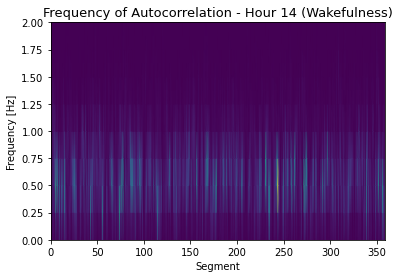

In [62]:
show_spectogram_nolog(freqs, spect, size=360)

In [48]:
data7 = get_hour(7)

data.size = 72000000


In [49]:
autocorrelation = []
for i in range(0, 3600, 10):
    data = data7[second_to_sample(i):second_to_sample(i+10)]
    data = low_pass_filter(data)
    
#     autocorrelation = []
    shifts = [j for j in range(10000, 100000, 10)]
    
    for shift in shifts:
        correlation = np.corrcoef(data[:-shift], data[shift:])[0,1]
        autocorrelation.append(correlation)
    
    print(i, len(shifts))



0 9000
10 9000
20 9000
30 9000
40 9000
50 9000
60 9000
70 9000
80 9000
90 9000
100 9000
110 9000
120 9000
130 9000
140 9000
150 9000
160 9000
170 9000
180 9000
190 9000
200 9000
210 9000
220 9000
230 9000
240 9000
250 9000
260 9000
270 9000
280 9000
290 9000
300 9000
310 9000
320 9000
330 9000
340 9000
350 9000
360 9000
370 9000
380 9000
390 9000
400 9000
410 9000
420 9000
430 9000
440 9000
450 9000
460 9000
470 9000
480 9000
490 9000
500 9000
510 9000
520 9000
530 9000
540 9000
550 9000
560 9000
570 9000
580 9000
590 9000
600 9000
610 9000
620 9000
630 9000
640 9000
650 9000
660 9000
670 9000
680 9000
690 9000
700 9000
710 9000
720 9000
730 9000
740 9000
750 9000
760 9000
770 9000
780 9000
790 9000
800 9000
810 9000
820 9000
830 9000
840 9000
850 9000
860 9000
870 9000
880 9000
890 9000
900 9000
910 9000
920 9000
930 9000
940 9000
950 9000
960 9000
970 9000
980 9000
990 9000
1000 9000
1010 9000
1020 9000
1030 9000
1040 9000
1050 9000
1060 9000
1070 9000
1080 9000
1090 9000
1100 9000
1

In [63]:
def show_spectogram_nolog(frequencies, spectrum: np.array, size=360):
    """
    :param frequencies: relevant frequencies - eventually takes the first 30
    :param spectrum: magnitudes of the relevant frequencies in each bin
    :param size: number of bins (default is one hour with bins' length 10sec - 360
    :return: shows / saves spectogram
    """
    # segmentation and plot
    plt.pcolormesh([i for i in range(size)], frequencies[:9], np.abs(np.transpose(spectrum[:, :9])),
                   shading='gouraud')
    plt.title('Frequency of Autocorrelation - Hour 7 (Sleep)', fontsize=13)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Segment')
    plt.show()
#     plt.savefig('spectogram')
    plt.close()

360


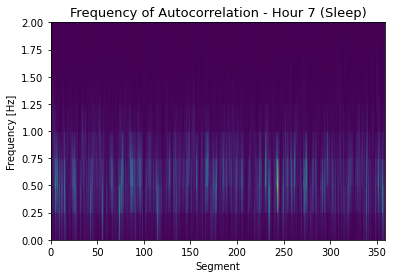

In [64]:
auto7 = np.array(autocorrelation)
freqs7, spect7 = welch_psd_per_bin(auto7, bin_length_sec=4.5, nperseg=4000, sf=1000, noverlap=2000)
show_spectogram_nolog(freqs7, spect7, size=360)